# Fantasy Premier League Data Exploration

This notebook helps you explore and analyze FPL data from the API and CDF.


In [1]:
import sys
sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.fpl_client import FPLClient

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Fetch Data from FPL API


In [2]:
# Initialize FPL client
client = FPLClient()

# Get bootstrap data
print("Fetching bootstrap data...")
bootstrap = client.get_bootstrap_static()

print(f"Players: {len(bootstrap['elements'])}")
print(f"Teams: {len(bootstrap['teams'])}")
print(f"Gameweeks: {len(bootstrap['events'])}")


Fetching bootstrap data...
Players: 758
Teams: 20
Gameweeks: 38


## 2. Player Analysis


In [3]:
# Convert players to DataFrame
players_df = pd.DataFrame(bootstrap['elements'])

# Add position names
position_map = {1: 'GKP', 2: 'DEF', 3: 'MID', 4: 'FWD'}
players_df['position_name'] = players_df['element_type'].map(position_map)

# Add team names
teams_df = pd.DataFrame(bootstrap['teams'])
team_map = teams_df.set_index('id')['name'].to_dict()
players_df['team_name'] = players_df['team'].map(team_map)

# Convert price
players_df['price'] = players_df['now_cost'] / 10

players_df.head()


,can_transact,can_select,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,...,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,defensive_contribution_per_90,position_name,team_name,price
0,True,True,NaN,NaN,154561,0,0,4,-4,1,...,53,4,6,1,1.0,0.53,0.00,GKP,Arsenal,5.9
1,True,True,NaN,NaN,109745,0,0,-3,3,0,...,567,78,259,34,0.0,0.00,0.00,GKP,Arsenal,4.2
2,True,False,0.0,0.0,463748,0,0,0,0,0,...,534,67,332,47,0.0,0.00,0.00,GKP,Arsenal,4.0
3,True,True,NaN,NaN,551221,0,0,-1,1,0,...,502,50,363,52,0.0,0.00,0.00,GKP,Arsenal,3.9
4,True,True,0.0,0.0,226597,0,0,3,-3,3,...,2,1,24,8,1.0,0.64,9.09,DEF,Arsenal,6.3


## 3. Top Players by Total Points


In [4]:
# Top 20 players
top_players = players_df.nlargest(20, 'total_points')[['web_name', 'team_name', 'position_name', 'total_points', 'price', 'selected_by_percent']]

print("Top 20 Players by Total Points:")
print(top_players.to_string(index=False))


Top 20 Players by Total Points:
     web_name      team_name position_name  total_points  price selected_by_percent
      Haaland       Man City           FWD           122   15.0                72.9
        Muñoz Crystal Palace           DEF            89    6.1                26.6
      Semenyo    Bournemouth           MID            83    7.7                47.2
        Guéhi Crystal Palace           DEF            83    5.1                35.9
         Rice        Arsenal           MID            82    7.1                21.8
      Gabriel        Arsenal           DEF            81    6.3                16.5
       Thiago      Brentford           FWD            80    6.8                27.8
     Chalobah        Chelsea           DEF            79    5.2                10.8
     J.Timber        Arsenal           DEF            78    6.4                35.0
      Lacroix Crystal Palace           DEF            78    5.1                 6.6
     Bruno G.      Newcastle           MID  

## 4. Value Analysis - Points per Million


In [5]:
# Calculate points per million
players_df['points_per_million'] = players_df['total_points'] / players_df['price']

# Filter players with at least 90 minutes played
active_players = players_df[players_df['minutes'] > 90].copy()

# Top value players by position
for position in ['GKP', 'DEF', 'MID', 'FWD']:
    pos_players = active_players[active_players['position_name'] == position]
    top_value = pos_players.nlargest(10, 'points_per_million')[['web_name', 'team_name', 'total_points', 'price', 'points_per_million']]
    
    print(f"\n{position} - Best Value:")
    print(top_value.to_string(index=False))



GKP - Best Value:
 web_name      team_name  total_points  price  points_per_million
    Roefs     Sunderland            64    4.7           13.617021
 Pickford        Everton            66    5.5           12.000000
Henderson Crystal Palace            60    5.1           11.764706
 Petrović    Bournemouth            52    4.5           11.555556
  Vicario          Spurs            57    5.0           11.400000
  Sánchez        Chelsea            54    4.8           11.250000
     Raya        Arsenal            66    5.9           11.186441
     Pope      Newcastle            55    5.1           10.784314
 Dúbravka        Burnley            43    4.0           10.750000
 Martinez    Aston Villa            54    5.1           10.588235

DEF - Best Value:
  web_name      team_name  total_points  price  points_per_million
     Keane        Everton            75    4.6           16.304348
     Guéhi Crystal Palace            83    5.1           16.274510
      Cash    Aston Villa          

## 5. Your League - Null digge damer igjen på Meny


In [14]:
# Your league ID
LEAGUE_ID = "988627/"  # Null digge damer igjen på Meny

# Get league standings
print("Fetching league data...")
league_data = client.get_league_standings(LEAGUE_ID)

league_info = league_data['league']
standings = league_data['standings']['results']

print(f"\nLeague: {league_info['name']}")
print(f"Total managers: {len(standings)}")
print("\n" + "="*80)
print("LEAGUE STANDINGS")
print("="*80)


Fetching league data...

League: OMS
Total managers: 10

LEAGUE STANDINGS


In [15]:
# Create DataFrame of standings
standings_df = pd.DataFrame(standings)

# Display key columns
display_cols = ['rank', 'player_name', 'entry_name', 'total', 'event_total']
standings_display = standings_df[display_cols].copy()
standings_display.columns = ['Rank', 'Manager', 'Team Name', 'Total Points', 'This GW']

print(standings_display.to_string(index=False))
print("\n" + "="*80)


 Rank          Manager            Team Name  Total Points  This GW
    1 Elias Gunnarsson    Claude-Maurice FC           814        0
    2      Toan Nguyen          Daskeladden           810        0
    3        Tuan Tran      Gunners & Roses           797        0
    4        Toan Tran              TeamOne           778        0
    5           Nam Vo              Nam2526           773        0
    6          Hai Bui   Excuisite Jamboree           727        0
    7         Tom Tran       Bruno-no-no-no           713        0
    8        Kenny Bui               Bui FC           689        0
    9    Kasper Heigre             Lurabyen           672        0
   10   Lina Halvorsen Nothing else Madders           642        0



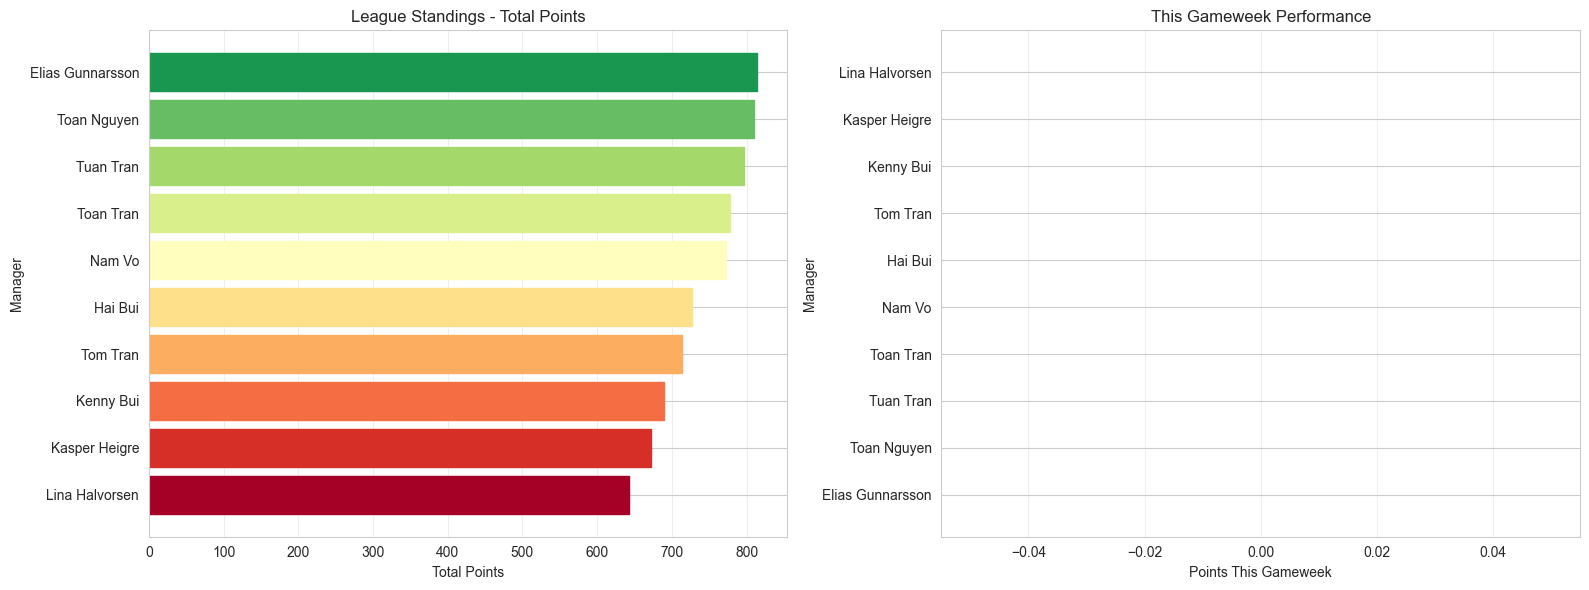

In [16]:
# Visualize league standings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Total points comparison
standings_sorted = standings_df.sort_values('total', ascending=True)
bars1 = ax1.barh(standings_sorted['player_name'], standings_sorted['total'])

# Color the bars by rank
colors_rank = plt.cm.RdYlGn_r(standings_sorted['rank'] / standings_sorted['rank'].max())
for bar, color in zip(bars1, colors_rank):
    bar.set_color(color)

ax1.set_xlabel('Total Points')
ax1.set_ylabel('Manager')
ax1.set_title('League Standings - Total Points')
ax1.grid(axis='x', alpha=0.3)

# This gameweek comparison
standings_sorted_gw = standings_df.sort_values('event_total', ascending=True)
bars2 = ax2.barh(standings_sorted_gw['player_name'], standings_sorted_gw['event_total'])

# Color by this gameweek performance
colors_gw = plt.cm.RdYlGn(standings_sorted_gw['event_total'] / standings_sorted_gw['event_total'].max())
for bar, color in zip(bars2, colors_gw):
    bar.set_color(color)

ax2.set_xlabel('Points This Gameweek')
ax2.set_ylabel('Manager')
ax2.set_title('This Gameweek Performance')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Manager History - Performance Over Time


In [17]:
# Get current gameweek
current_gw = client.get_current_gameweek()
print(f"Current gameweek: {current_gw}")

# Fetch history for top 5 managers (to avoid too many API calls)
top_5_managers = standings_df.nlargest(5, 'total')

manager_histories = []

for _, manager in top_5_managers.iterrows():
    entry_id = manager['entry']
    manager_name = manager['player_name']
    
    print(f"Fetching history for {manager_name}...")
    
    try:
        history = client.get_entry_history(entry_id)
        
        for gw in history.get('current', []):
            manager_histories.append({
                'manager': manager_name,
                'gameweek': gw['event'],
                'points': gw['points'],
                'total_points': gw['total_points'],
                'rank': gw['overall_rank'],
                'gw_rank': gw['rank'],
                'transfers': gw['event_transfers'],
                'transfer_cost': gw['event_transfers_cost'],
                'value': gw['value'] / 10  # Convert to millions
            })
    except Exception as e:
        print(f"  Error: {e}")
        continue

history_df = pd.DataFrame(manager_histories)
print(f"\nLoaded history for {history_df['manager'].nunique()} managers")


Current gameweek: 15
Fetching history for Elias Gunnarsson...
Fetching history for Toan Nguyen...
Fetching history for Tuan Tran...
Fetching history for Toan Tran...
Fetching history for Nam Vo...

Loaded history for 5 managers


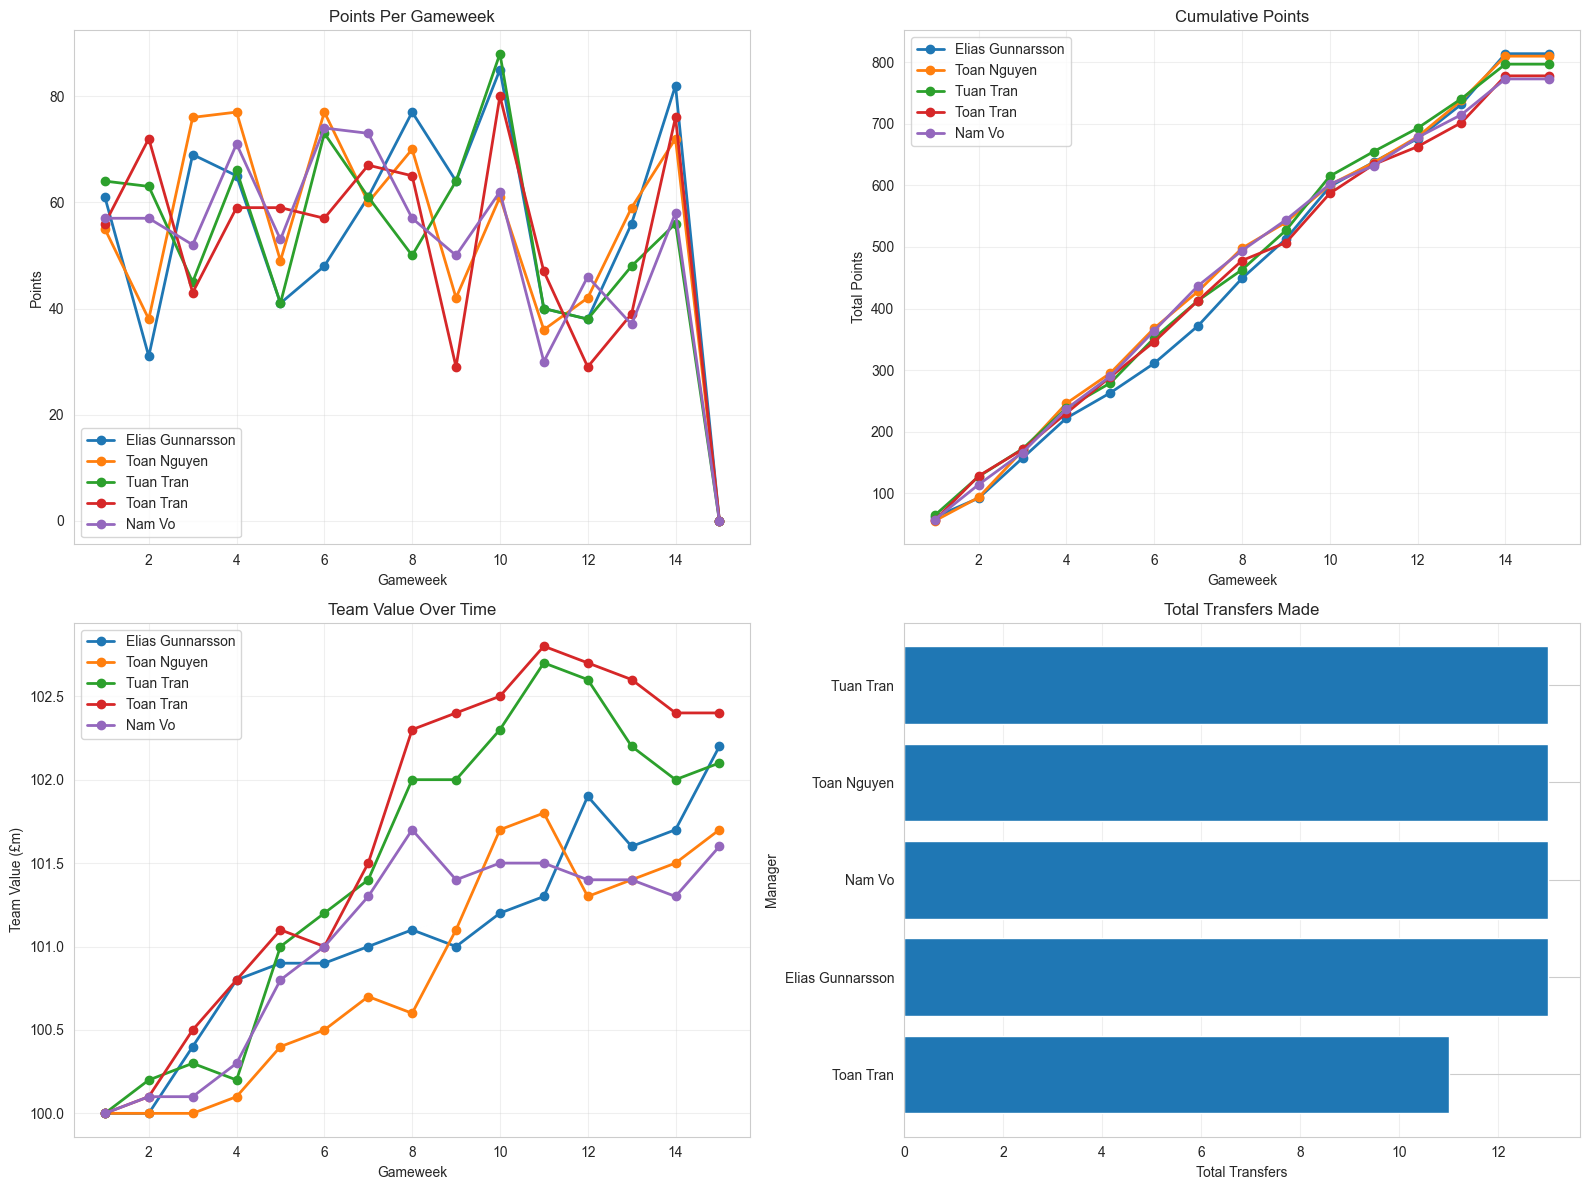

In [18]:
# Plot gameweek points over time
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Points per gameweek
ax1 = axes[0, 0]
for manager in history_df['manager'].unique():
    manager_data = history_df[history_df['manager'] == manager]
    ax1.plot(manager_data['gameweek'], manager_data['points'], marker='o', label=manager, linewidth=2)

ax1.set_xlabel('Gameweek')
ax1.set_ylabel('Points')
ax1.set_title('Points Per Gameweek')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative points
ax2 = axes[0, 1]
for manager in history_df['manager'].unique():
    manager_data = history_df[history_df['manager'] == manager]
    ax2.plot(manager_data['gameweek'], manager_data['total_points'], marker='o', label=manager, linewidth=2)

ax2.set_xlabel('Gameweek')
ax2.set_ylabel('Total Points')
ax2.set_title('Cumulative Points')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Team value over time
ax3 = axes[1, 0]
for manager in history_df['manager'].unique():
    manager_data = history_df[history_df['manager'] == manager]
    ax3.plot(manager_data['gameweek'], manager_data['value'], marker='o', label=manager, linewidth=2)

ax3.set_xlabel('Gameweek')
ax3.set_ylabel('Team Value (£m)')
ax3.set_title('Team Value Over Time')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Transfers made
ax4 = axes[1, 1]
transfer_summary = history_df.groupby('manager')['transfers'].sum().sort_values()
ax4.barh(transfer_summary.index, transfer_summary.values)
ax4.set_xlabel('Total Transfers')
ax4.set_ylabel('Manager')
ax4.set_title('Total Transfers Made')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Manager Team Details - Current Squads


In [19]:
# Function to get manager's current team
def get_manager_team(entry_id, manager_name, gameweek):
    """Get a manager's team for a specific gameweek"""
    try:
        picks_data = client.get_entry_picks(entry_id, gameweek)
        picks = picks_data['picks']
        
        team_players = []
        for pick in picks:
            player_id = pick['element']
            player = players_df[players_df['id'] == player_id].iloc[0]
            
            team_players.append({
                'manager': manager_name,
                'player': player['web_name'],
                'team': player['team_name'],
                'position': player['position_name'],
                'price': player['price'],
                'points': player['total_points'],
                'is_captain': pick['is_captain'],
                'is_vice_captain': pick['is_vice_captain'],
                'multiplier': pick['multiplier'],
                'position_order': pick['position']
            })
        
        return pd.DataFrame(team_players)
    except Exception as e:
        print(f"Error fetching team for {manager_name}: {e}")
        return pd.DataFrame()

# Get current teams for top 3 managers
print(f"Fetching current teams for gameweek {current_gw}...\n")

top_3_managers = standings_df.nlargest(3, 'total')
all_teams = []

for _, manager in top_3_managers.iterrows():
    entry_id = manager['entry']
    manager_name = manager['player_name']
    
    print(f"Loading {manager_name}'s team...")
    team_df = get_manager_team(entry_id, manager_name, current_gw)
    
    if not team_df.empty:
        all_teams.append(team_df)
        
        # Display team
        print(f"\n{manager_name}'s Team (GW{current_gw}):")
        print(f"Total team value: £{team_df['price'].sum():.1f}m")
        print(f"Total points: {team_df['points'].sum()}")
        
        display_team = team_df.sort_values('position_order')[['position', 'player', 'team', 'price', 'points']]
        display_team['captain'] = team_df['is_captain'].map({True: '(C)', False: ''})
        display_team.loc[team_df['is_vice_captain'], 'captain'] = '(VC)'
        
        print(display_team[['position', 'player', 'team', 'captain', 'price', 'points']].to_string(index=False))
        print("\n" + "-"*80)

if all_teams:
    combined_teams = pd.concat(all_teams, ignore_index=True)


Fetching current teams for gameweek 15...

Loading Elias Gunnarsson's team...

Elias Gunnarsson's Team (GW15):
Total team value: £102.1m
Total points: 977
position      player           team captain  price  points
     GKP   Henderson Crystal Palace            5.1      60
     DEF   Tarkowski        Everton            5.4      71
     DEF       Guéhi Crystal Palace            5.1      83
     DEF      Virgil      Liverpool            6.0      57
     MID      Rogers    Aston Villa            6.9      61
     MID      Mbeumo        Man Utd    (VC)    8.5      64
     MID    Grealish        Everton            6.6      62
     MID       Foden       Man City            8.4      76
     FWD      Mateta Crystal Palace            8.1      59
     FWD     Haaland       Man City     (C)   15.0     122
     FWD      Thiago      Brentford            6.8      80
     GKP    Dúbravka        Burnley            4.0      43
     MID      Cherki       Man City            6.4      40
     DEF Pedro Porr

## 8. League Statistics


In [20]:
# League statistics
print("LEAGUE STATISTICS")
print("="*80)

# Points distribution
print(f"\nPoints Distribution:")
print(f"  Average: {standings_df['total'].mean():.0f}")
print(f"  Median: {standings_df['total'].median():.0f}")
print(f"  Highest: {standings_df['total'].max():.0f} ({standings_df.loc[standings_df['total'].idxmax(), 'player_name']})")
print(f"  Lowest: {standings_df['total'].min():.0f} ({standings_df.loc[standings_df['total'].idxmin(), 'player_name']})")
print(f"  Gap (1st to Last): {standings_df['total'].max() - standings_df['total'].min():.0f} points")

# This gameweek stats
print(f"\nThis Gameweek (GW{current_gw}):")
print(f"  Average: {standings_df['event_total'].mean():.0f}")
print(f"  Best: {standings_df['event_total'].max():.0f} ({standings_df.loc[standings_df['event_total'].idxmax(), 'player_name']})")
print(f"  Worst: {standings_df['event_total'].min():.0f} ({standings_df.loc[standings_df['event_total'].idxmin(), 'player_name']})")

# Most consistent performers (lowest std dev in gameweek scores)
if not history_df.empty:
    consistency = history_df.groupby('manager')['points'].agg(['mean', 'std']).sort_values('std')
    print(f"\nMost Consistent (lowest variation):")
    for i, (manager, stats) in enumerate(consistency.head(3).iterrows(), 1):
        print(f"  {i}. {manager}: {stats['mean']:.1f} ± {stats['std']:.1f} points/GW")
    
    print(f"\nMost Volatile (highest variation):")
    for i, (manager, stats) in enumerate(consistency.tail(3).iterrows(), 1):
        print(f"  {i}. {manager}: {stats['mean']:.1f} ± {stats['std']:.1f} points/GW")


LEAGUE STATISTICS

Points Distribution:
  Average: 742
  Median: 750
  Highest: 814 (Elias Gunnarsson)
  Lowest: 642 (Lina Halvorsen)
  Gap (1st to Last): 172 points

This Gameweek (GW15):
  Average: 0
  Best: 0 (Elias Gunnarsson)
  Worst: 0 (Elias Gunnarsson)

Most Consistent (lowest variation):
  1. Nam Vo: 51.8 ± 18.8 points/GW
  2. Tuan Tran: 53.1 ± 20.1 points/GW
  3. Toan Nguyen: 54.3 ± 20.8 points/GW

Most Volatile (highest variation):
  1. Toan Nguyen: 54.3 ± 20.8 points/GW
  2. Toan Tran: 51.9 ± 21.3 points/GW
  3. Elias Gunnarsson: 54.5 ± 22.2 points/GW


## 9. Save Data to CSV (Optional)


In [21]:
# Uncomment to save data to CSV files
# standings_df.to_csv('league_standings.csv', index=False)
# history_df.to_csv('manager_histories.csv', index=False)
# players_df.to_csv('all_players.csv', index=False)
# print("Data saved to CSV files!")
